## Getting started with bombcell

#### Install bombcell

Create a conda environment
```bash
conda create -n bombcell python=3.11
conda activate bombcell
```
Clone latest bombcell repository from github
```bash
git clone https://github.com/Julie-Fabre/bombcell.git
```
Install bombcell from local repository
```bash
cd bombcell/pyBombCell
# you could do `pip install .`, but uv is much quicker!
pip install uv
uv pip install . # or uv pip install -e . (-e for editable mode)
```

#### Imports

In [2]:
import os, sys
from pathlib import Path
from pprint import pprint 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt

In [3]:
# Optional

# # Add bombcell to Python path if NOT installed with pip
# # If notebook is running in bombcell repo:
# demo_dir = Path(os.getcwd())
# pyBombCell_dir = demo_dir.parent
# # Else:
# # pyBombCell_dir = "path/to/bombcell/repository/root"
# sys.path.append(str(pyBombCell_dir))

In [4]:
%load_ext autoreload
%autoreload 2

import bombcell as bc

/home/jf5479/anaconda3/envs/bombcell/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define data paths and get parameters

By default: path to BombCell's toy dataset

In [ ]:
# Replace with your kilosort directory
ks_dir = "toy_data"

# Set bombcell's output directory
save_path = Path(ks_dir) / "bombcell"

print(f"Using kilosort directory: {ks_dir}")

In [5]:
## For Neuropixels probes, provide raw and meta files
# Leave 'None' if no raw data
raw_file_path = None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0_bc_decompressed.imec0.ap.bin" # ks_dir
meta_file_path = None#"/home/julie/Dropbox/Example datatsets/JF093_2023-03-09_site1/site1/2023-03-09_JF093_g0_t0.imec0.ap.meta"
param = bc.get_default_parameters(ks_dir, 
                                  raw_file=raw_file_path,
                                  meta_file=meta_file_path,
                                  kilosort_version=2)

print("Bombcell parameters:")
pprint(param)

Bombcell parameters:
{'computeDistanceMetrics': False,
 'computeDrift': False,
 'computeSpatialDecay': True,
 'computeTimeChunks': False,
 'decompress_data': False,
 'deltaTimeChunk': 360,
 'detrendWaveform': True,
 'driftBinSize': 60,
 'duplicateSpikeWindow_s': 1e-05,
 'ephysKilosortPath': '/home/jf5479/Dropbox/Example '
                      'datatsets/JF093_2023-03-09_site1',
 'ephys_meta_file': None,
 'ephys_sample_rate': 30000,
 'extractRaw': True,
 'gain_to_uV': None,
 'hillOrLlobetMethod': True,
 'isoDmin ': 20,
 'keep_only_somatic': True,
 'lratioMax': 0.3,
 'maxDrift': 100,
 'maxMainPeakToTroughRatio_nonSomatic': 0.8,
 'maxNPeaks': 2,
 'maxNTroughs': 1,
 'maxPeak1ToPeak2Ratio_nonSomatic': 3,
 'maxPercSpikesMissing': 20,
 'maxRPVviolations': 0.1,
 'maxScndPeakToTroughRatio_noise': 0.8,
 'maxSpatialDecaySlopeExp': 0.1,
 'maxWvBaselineFraction': 0.3,
 'maxWvDuration': 1150,
 'minAmplitude': 40,
 'minNumSpikes': 300,
 'minPresenceRatio': 0.7,
 'minSNR': 5,
 'minSpatialDecaySlope':

In [6]:
## For non-Neuropixels probes, provide raw files AND specify conversion factor to uV
# raw_file_path = "" # .bin, .dat...
# param = bc.get_default_parameters(ks_dir, 
#                                   raw_file=raw_file_path,
#                                   meta_file=meta_file_path)

# print("BombCell parameters:")
# pprint(param)
# param["gain_to_uV"] = None # needs to be passed explicitly to bc.get_default_parameters
# param["ephys_sampling_rate"] = 30_000
# param["nChannels"] = 385
# param["nSyncChannels"] = 1

##### Optionally customize parameters

In [7]:

# param["maxRPVviolations"] = 0.1
param["computeDistanceMetrics"] = 0
param["computeDrift"] = 0
# param["computeTimeChunks"] = 0
# ...
param['reextractRaw'] = False

#### Run bombcell, get unit types and save results 

Computing bombcell quality metrics: 100%|██████████| 143/143 units


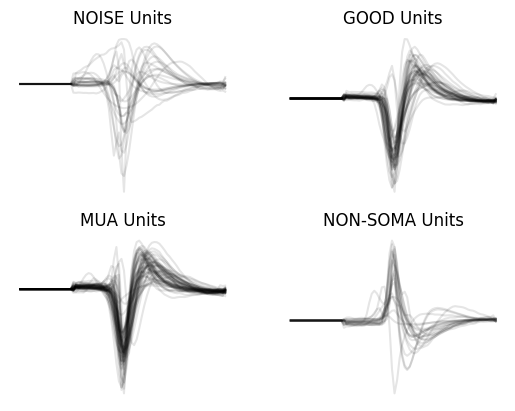

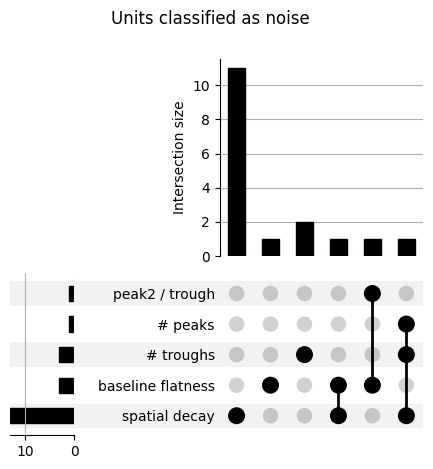

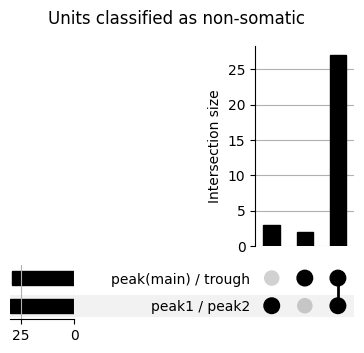

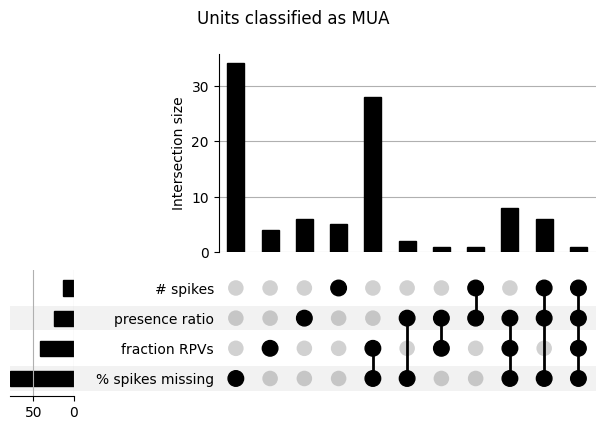

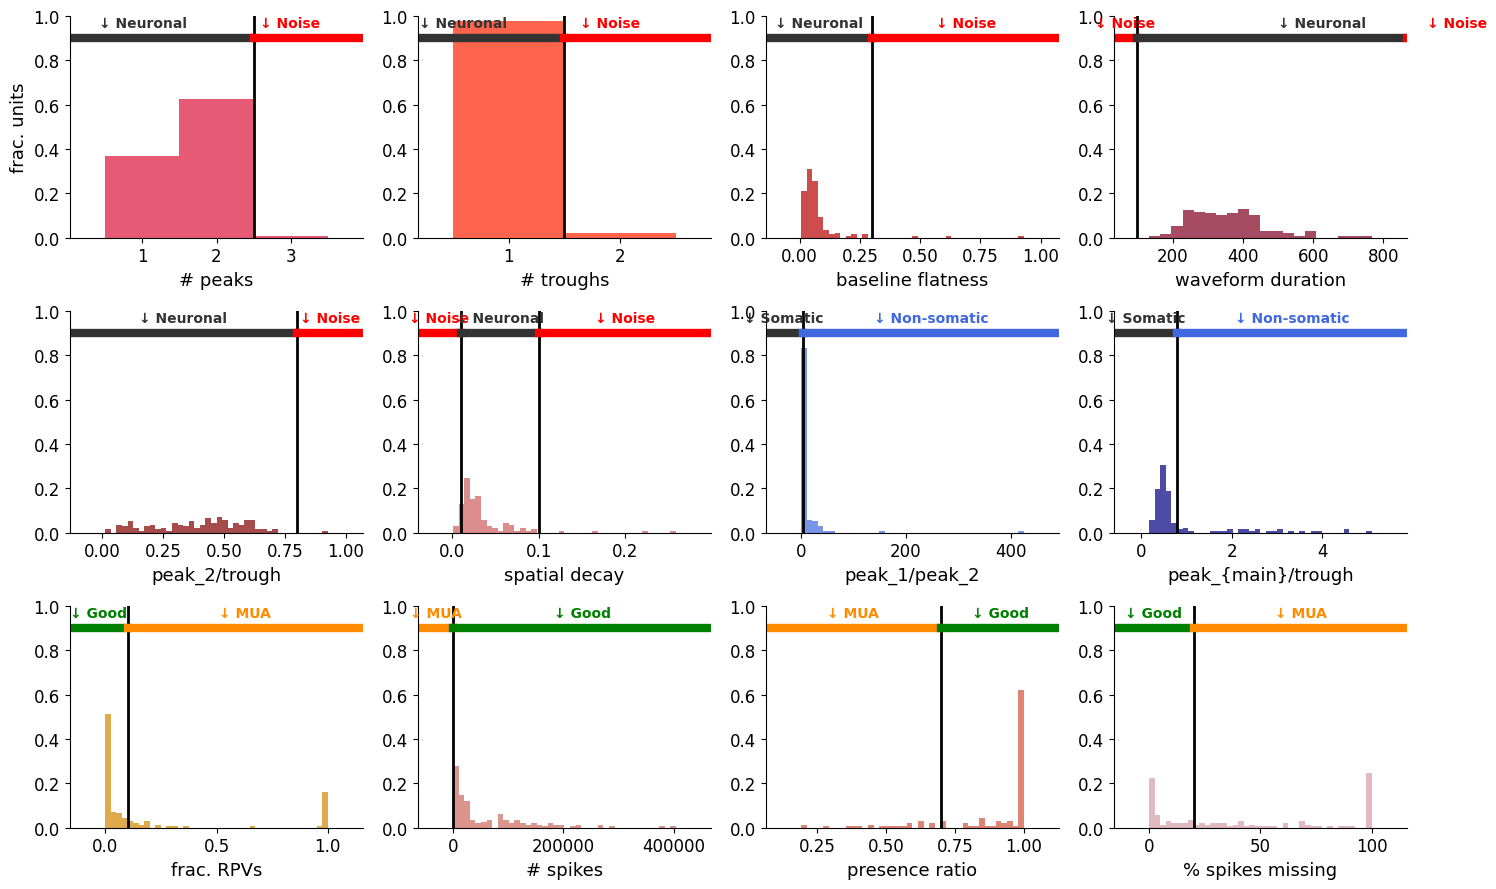

All expected metrics were successfully saved.


In [6]:
(
    quality_metrics,
    param,
    unit_type,
    unit_type_string,
) = bc.run_bombcell(
    ks_dir, save_path, param
)

Reload quality metrics table

In [87]:
# quality metric values
quality_metrics_table = pd.DataFrame(quality_metrics)
quality_metrics_table.insert(0, 'Bombcell_unit_type', unit_type_string)
quality_metrics_table

,Bombcell_unit_type,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,peak1ToPeak2Ratio,troughToPeak2Ratio,mainPeak_before_width,mainTrough_width,percentageSpikesMissing_gaussian,percentageSpikesMissing_symmetric,RPV_window_index,fractionRPVs_estimatedTauR,presenceRatio,maxDriftEstimate,cumDriftEstimate,rawAmplitude,signalToNoiseRatio,isolationDistance,Lratio,silhouetteScore,useTheseTimesStart,useTheseTimesStop,maxChannels
0,MUA,0,12531.0,2.0,1.0,300.000000,0.025852,0.027249,0.397105,0.397105,0.578461,4.353314,NaN,3.762758,39.030957,39.281907,0.0,0.167895,1.000000,36.591587,140.981445,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,1
1,NOISE,1,27148.0,2.0,1.0,433.333333,0.001318,0.282522,0.691792,0.691792,1.000000,1.445521,NaN,10.218586,87.973318,32.063762,0.0,1.000000,1.000000,13.275711,154.386139,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,0
2,MUA,2,16230.0,1.0,1.0,600.000000,0.022720,0.159244,0.345212,0.345212,0.082144,35.264683,11.822669,8.685377,100.000000,13.894636,0.0,1.000000,1.000000,88.453358,223.917088,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,1
3,MUA,3,5801.0,2.0,1.0,400.000000,0.011218,0.066674,0.395594,0.395594,0.523529,4.828471,NaN,6.113630,69.075778,43.712401,0.0,0.956110,0.780822,29.536861,337.050392,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,2
4,GOOD,4,26562.0,2.0,1.0,300.000000,0.026757,0.029057,0.543130,0.543130,0.749015,2.458134,NaN,4.727452,4.408649,4.191314,0.0,0.085937,1.000000,30.199593,121.033363,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,MUA,138,5489.0,1.0,1.0,233.333333,0.031424,0.020925,0.318595,0.318595,0.074663,42.039429,NaN,2.918676,69.847127,41.268992,0.0,0.189014,1.000000,28.169922,165.417969,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,125
139,MUA,139,5700.0,1.0,1.0,466.666667,0.026308,0.073812,0.440791,0.440791,0.321497,7.056509,NaN,6.648482,50.378817,40.031562,0.0,0.308229,1.000000,32.089600,217.536865,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,138
140,NON-SOMA,140,99.0,2.0,1.0,400.000000,0.066786,0.034273,0.255365,0.908673,3.558328,1.100506,2.348477,7.292709,100.000000,0.000000,0.0,0.000000,0.356164,74.517578,514.809448,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,149
141,MUA,141,151.0,2.0,1.0,466.666667,0.033076,0.066439,0.410169,0.410169,0.696073,3.502532,15.599846,6.459551,1.361762,0.000000,0.0,0.000000,0.452055,59.163055,349.275726,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,30


In [88]:
# boolean table, if quality metrics pass threshold given parameters
boolean_quality_metrics_table = bc.make_qm_table(
    quality_metrics, param, unit_type_string
)
boolean_quality_metrics_table

,unit_type,Original ID,# peaks,# troughs,waveform duration,baseline flatness,peak2 / trough,spatial decay,# spikes,% spikes missing,presence ratio,fraction RPVs,non somatic,peak(main) / trough,peak1 / peak2
0,MUA,0,False,False,False,False,False,False,False,True,False,True,False,False,False
1,NOISE,1,False,False,False,False,False,True,False,True,False,True,False,False,False
2,MUA,2,False,False,False,False,False,False,False,True,False,True,False,False,False
3,MUA,3,False,False,False,False,False,False,False,True,False,True,False,False,False
4,GOOD,4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,MUA,138,False,False,False,False,False,False,False,True,False,True,False,False,False
139,MUA,139,False,False,False,False,False,False,False,True,False,True,False,False,False
140,NON-SOMA,140,False,False,False,False,False,False,True,True,True,False,True,True,True
141,MUA,141,False,False,False,False,False,False,True,False,True,False,False,False,False


Example: get all quality metrics for unit 10

In [89]:
u = 12

units = quality_metrics_table.phy_clusterID
quality_metrics_table.loc[units == u, :]

,Bombcell_unit_type,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,peak1ToPeak2Ratio,troughToPeak2Ratio,mainPeak_before_width,mainTrough_width,percentageSpikesMissing_gaussian,percentageSpikesMissing_symmetric,RPV_window_index,fractionRPVs_estimatedTauR,presenceRatio,maxDriftEstimate,cumDriftEstimate,rawAmplitude,signalToNoiseRatio,isolationDistance,Lratio,silhouetteScore,useTheseTimesStart,useTheseTimesStop,maxChannels
12,MUA,12,30364.0,2.0,1.0,366.666667,0.018541,0.046643,0.490515,0.490515,0.280021,7.280428,5.479138,5.23824,70.354724,42.510934,0.0,1.0,1.0,15.802353,71.53537,NaN,NaN,NaN,NaN,NaN,0.003833,4387.514967,14


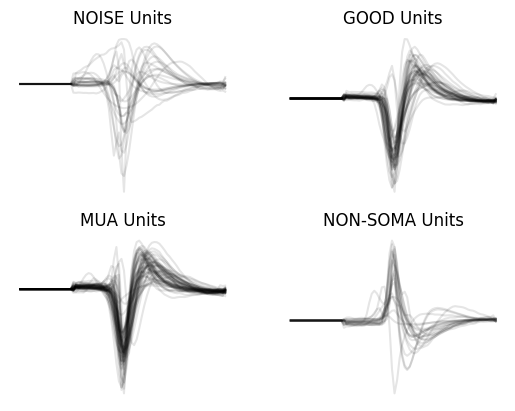

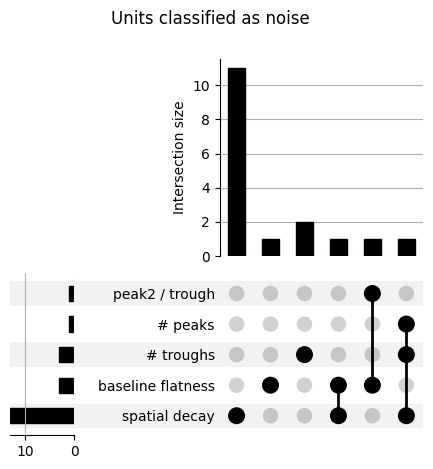

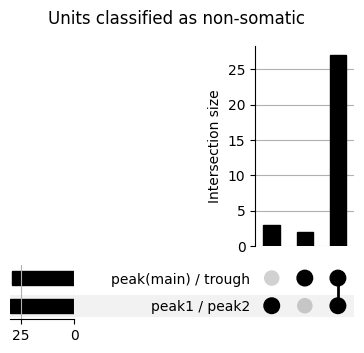

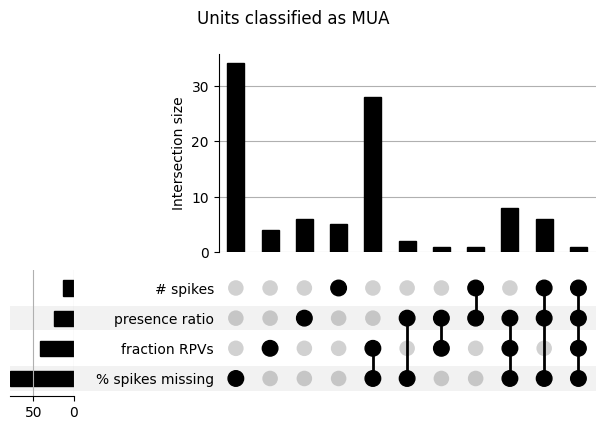

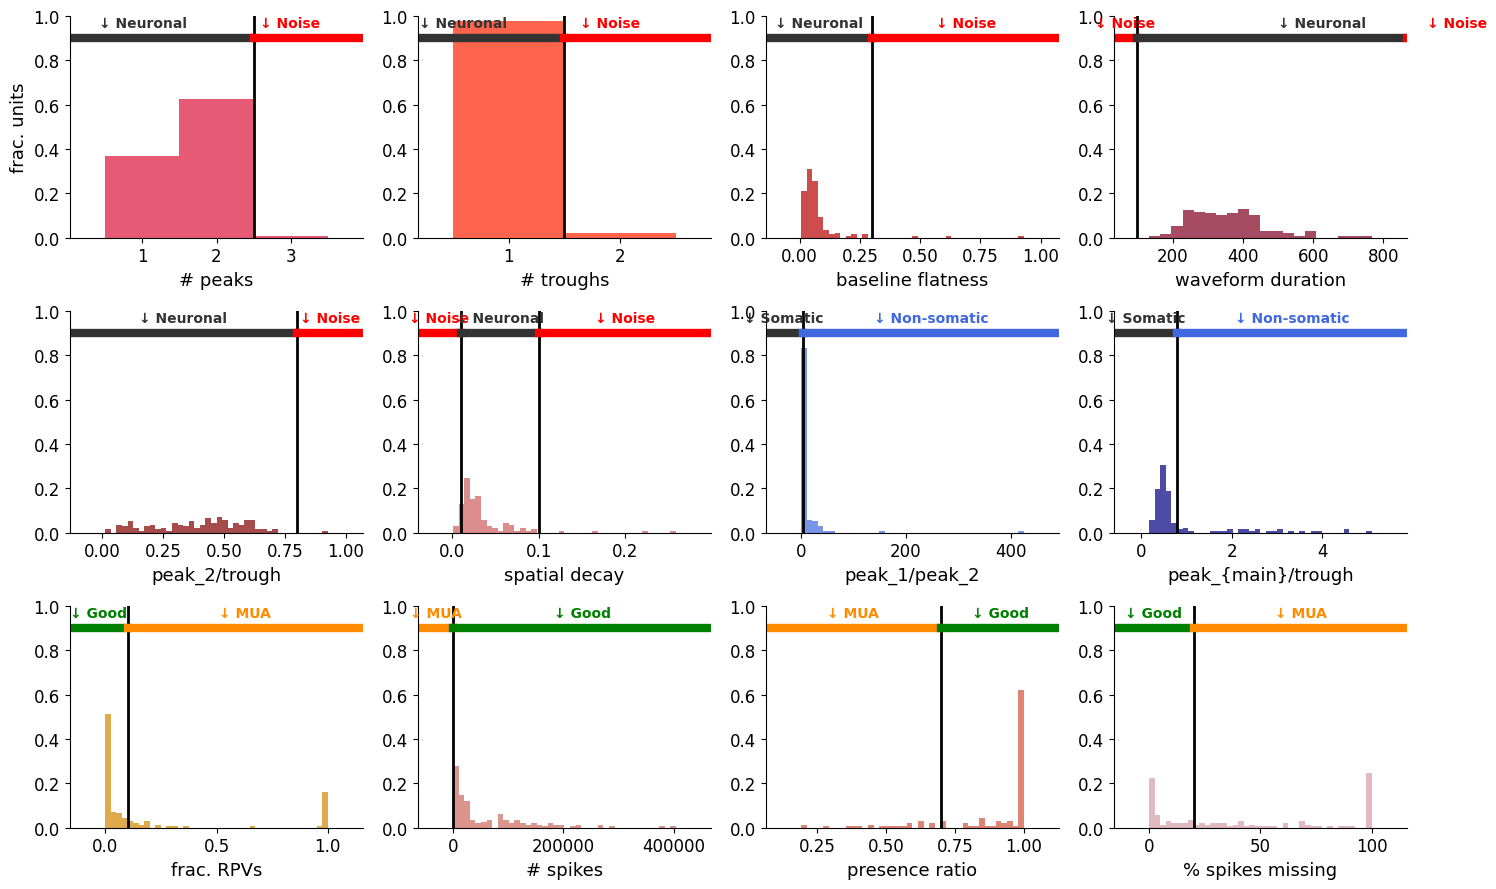

In [90]:
param["lratioMax"] = 0.3
unit_type, unit_type_string = bc.qm.get_quality_unit_type(
        param, quality_metrics
    )  # JF: this should be inside bc.get_all_quality_metrics
(
    spike_times_samples,
    spike_clusters, # actually spike_templates, but they're the same in bombcell
    template_waveforms,
    template_amplitudes,
    pc_features,
    pc_features_idx,
    channel_positions,
) = bc.load_ephys_data(ks_dir)
bc.plot_summary_data(quality_metrics, template_waveforms, unit_type, unit_type_string, param)


## Ephys Properties and Cell Type Classification

This section computes detailed electrophysiological properties and performs cell type classification based on waveform morphology and firing patterns.

BombCell can now compute detailed ephys properties and classify cell types based on waveform and firing patterns. This extends the quality metrics to include functional characterization of neurons.

In [ ]:
# Use the real dataset for ephys properties demonstration
ks_dir = "toy_data"
save_path = Path(ks_dir) / "bombcell"

print(f"Using kilosort directory: {ks_dir}")

Using kilosort directory: /home/jf5479/Dropbox/Example datatsets/JF093_2023-03-09_site1


In [6]:
# Load spike data needed for ephys properties
(
    spike_times_samples,
    spike_clusters,
    template_waveforms,
    template_amplitudes,
    pc_features,
    pc_features_idx,
    channel_positions,
) = bc.load_ephys_data(ks_dir)

In [18]:
# Compute ephys properties for cell type classification
ephys_param = bc.get_ephys_parameters(ks_dir)

# Compute all ephys properties using the correct function signature
ephys_properties, ephys_param = bc.run_all_ephys_properties(ks_dir, ephys_param)

Computing ephys properties for 143 units (unit-by-unit processing)...


Computing ephys properties: 100%|██████████| 143/143 [01:28<00:00,  1.62it/s]

Ephys properties computation complete!
Ephys properties saved to: /home/jf5479/Dropbox/Example datatsets/JF093_2023-03-09_site1/templates._bc_ephysProperties.parquet
Parameters saved to: /home/jf5479/Dropbox/Example datatsets/JF093_2023-03-09_site1/_bc_ephysParameters.parquet


Classifying striatum neurons...


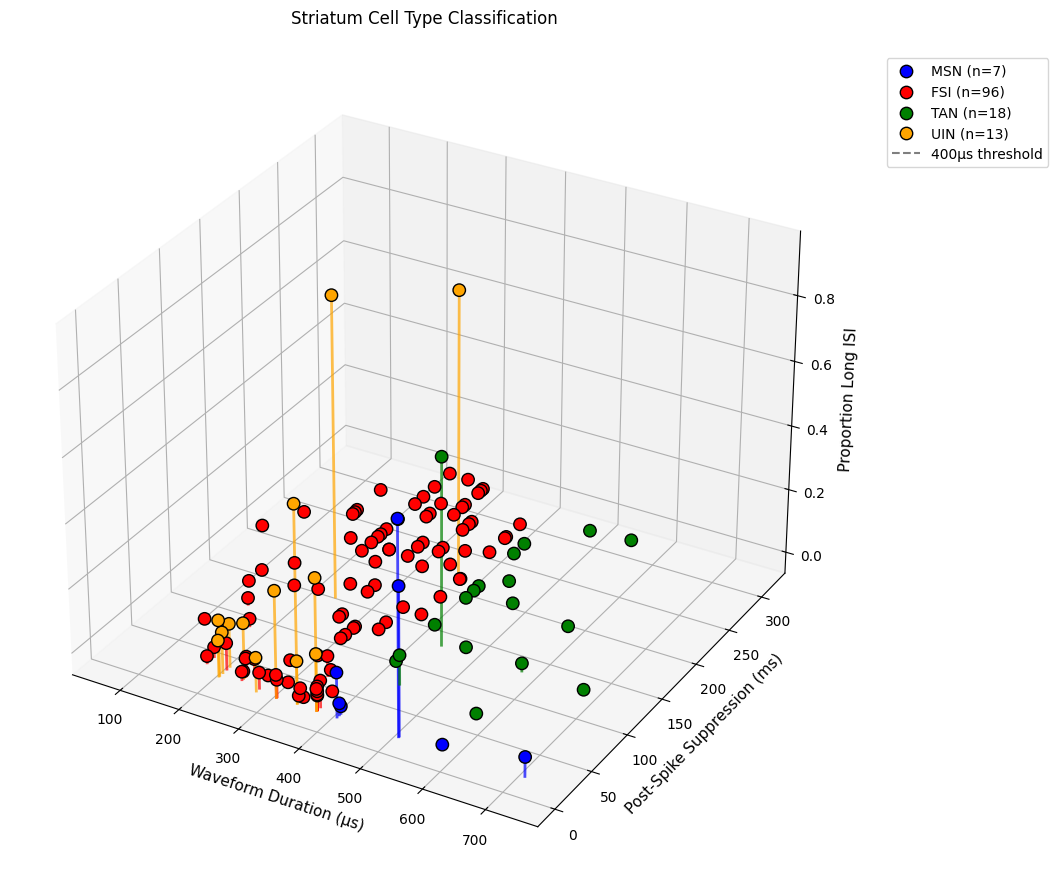

Plotted 134 units:
  Waveform duration range: 67-733 μs
  Post-spike suppression range: 0.0-314.0 ms
  Prop long ISI range: 0.000-0.926

Striatum cell type distribution:
  MSN: 7 (4.9%)
  FSI: 96 (67.1%)
  TAN: 18 (12.6%)
  UIN: 13 (9.1%)
  Unknown: 9 (6.3%)


In [21]:
# Cell type classification with automatic plot generation
# Specify brain region: 'cortex' or 'striatum'
brain_region = 'striatum'  # Change this to 'cortex' for cortical data

print(f"Classifying {brain_region} neurons...")
cell_types = bc.classify_and_plot_brain_region(ephys_properties, ephys_param, brain_region)

In [20]:
# Show classification results
if cell_types is not None:
    # Create combined results table
    ephys_df = pd.DataFrame(ephys_properties)
    ephys_properties_table = ephys_df.copy()
    ephys_properties_table['cell_type'] = cell_types
   
    print(ephys_properties_table)

     unit_id  postSpikeSuppression  acg_tau_rise  acg_tau_decay    isi_cv  \
0          0              0.143709           4.0            NaN  2.409037   
1          1              0.103158           5.0            NaN  4.072216   
2          2              0.155852           2.0            NaN  1.595281   
3          3              0.569312           3.0            NaN  2.676790   
4          4              0.000000          10.0            NaN  1.621838   
..       ...                   ...           ...            ...       ...   
138      138              0.152696           8.0            NaN  1.463302   
139      139              0.102382           0.0            NaN  1.194554   
140      140                   NaN           NaN            NaN       NaN   
141      141              0.000000           NaN            NaN  3.832929   
142      142              0.000000           NaN            NaN  1.639554   

      isi_cv2  isi_skewness  prop_long_isi  waveform_duration_peak_trough  